#  YaProfi baseline

In [285]:
from os import path
import re
import zipfile
import os
from tqdm import tqdm

class Dataloader():
  def __init__(self, root):
    self.root = root

  def load_data(self, zipf, verbose = None):
    with zipfile.ZipFile(zipf) as file:
       print('unpacking....')
       if verbose:
        for filename in tqdm(file.namelist()):
            print(filename)
            file.extract(filename)
       else:
         for filename in tqdm(file.namelist()):
            file.extract(filename)

    !mv $self.root/Test $self.root/query/sensors/records_data
    !mv $self.root/Train $self.root/mapping/sensors/records_data
    !rm $self.root/Train $self.root/Test

  def load_model(self, path):
    !unzip $path

  def load_repo(self,):
    !git clone https://github.com/naver/r2d2.git
    !git clone https://github.com/naver/deep-image-retrieval.git
    !git clone https://github.com/naver/kapture.git kapture
    !git clone https://github.com/naver/kapture-localization.git
    !mkdir repo
    !mv kapture r2d2 deep-image-retrieval kapture-localization repo
    

class Structure():

  def __init__(self, root):
    self.root = root
    self.way = {'query':'Test', 'mapping':'Train'}
    self.size = {}
    self.gt_mapping = ['/opt/src/gt_poses_2021-03-27-09-08-15.txt', '/opt/src/gt_poses_2021-03-27-10-17-01.txt', '/opt/src/gt_poses_2021-03-27-10-32-53.txt']
    self.gt_query = ['/opt/src/gt_poses_2021-03-27-03-30-47.txt','/opt/src/gt_poses_2021-03-31-12-33-50.txt']

  def mkstructure(self):
    !echo $self.root
    
    assert not path.exists(self.root)
    !mkdir $self.root
    !echo $self.root
    %cd $self.root
    !mkdir $self.root
    !mkdir $self.root/query
    !mkdir $self.root/mapping
    !mkdir $self.root/query/sensors
    !mkdir $self.root/mapping/sensors
    !mkdir $self.root/query/sensors/records_data
    !mkdir $self.root/mapping/sensors/records_data

    !mkdir $self.root/local_features
    !mkdir $self.root/global_features
    !mkdir $self.root/local_features/r2d2_500
    !mkdir $self.root/local_features/r2d2_500/keypoints
    !mkdir $self.root/local_features/r2d2_500/descriptors
    !mkdir $self.root/global_features/AP-GeM-LM18
    !mkdir $self.root/global_features/AP-GeM-LM18/global_features

    

  def __del__(self):
    %cd ..
    !rm -rf $self.root

  def mkfiles_txt(self,mode):
    !pwd
    !ls
    way = self.way[mode]
    records_camera = open(f'{self.root}/{mode}/sensors/records_camera.txt', "w")
    records_camera.write('# timestamp, device_id, image_path\n')

    sensor =  open(f'{self.root}/{mode}/sensors/sensors.txt', 'w')
    sensor.write('# sensor_id, name, sensor_type, [sensor_params]+\n')

    dates_fold = sorted(os.listdir(f'{self.root}/{mode}/sensors/records_data/{way}'))
    count = 0
    print(f'\nwriting sensor.txt, records_data.txt, trajectories.txt for {mode} .....')
    for j in dates_fold:
      path = list(filter(lambda x: x.split('.')[1]=='jpg',sorted(os.listdir(f'{self.root}/{mode}/sensors/records_data/{way}/'+ j +'/left'), \
                            key=lambda x: int(re.split(r't', x)[1].split('.')[0]))))
      for k in range(0,len(path)):
        if k % 20 == 0: 
          string_records_camera = f'{count}, sensor{count}, ' + f'{way}/'+ j + '/left/'+ path[k] +'\n'
          records_camera.write(string_records_camera)

          string_sensor = f'sensor{count}, , camera, PINHOLE, 1280, 720, 684.06805, 684.06805, 615.11951 , 345.32159 \n'
          sensor.write(string_sensor)
          count+=1 
        
    self.size[f'{mode}'] = count
    
    trajectories = open(f'{self.root}/{mode}/sensors/trajectories.txt','w')
    trajectories.write('# timestamp, device_id, qw, qx, qy, qz, tx, ty, tz\n')
    gt = self.gt_query if mode == 'query' else self.gt_mapping
    count = 0 
    for file_path in gt:
        with open(file_path,'r') as f:
            for string in f.readlines():
                timestamp, qw, qx, qy, qz, tx, ty, tz = string.split(' ')
                trajectories.write(f'{int(float(count))}, sensor{int(float(count))}, {qw}, {qx}, {qy}, {qz}, {tx}, {ty}, {tz}' +'\n')
                count+=1
    

    records_camera.close()
    sensor.close()
    trajectories.close()


In [277]:
gt_mapping = ['/opt/src/gt_poses_2021-03-27-09-08-15.txt', '/opt/src/gt_poses_2021-03-27-10-17-01.txt', '/opt/src/gt_poses_2021-03-27-10-32-53.txt']
gt_query = ['/opt/src/gt_poses_2021-03-27-03-30-47.txt','/opt/src/gt_poses_2021-03-31-12-33-50.txt']


trajectories = open('YaProfi/mapping/sensors/trajectories.txt','w')
trajectories.write('# timestamp, device_id, qw, qx, qy, qz, tx, ty, tz\n')
count = 0 
gt = gt_mapping 
for file_path in gt:
    with open(file_path,'r') as f:
        for string in f.readlines():
            timestamp, qw, qx, qy, qz, tx, ty, tz = string.split(' ')
            trajectories.write(f'{int(float(count))}, sensor{int(float(count))}, {qw}, {qx}, {qy}, {qz}, {tx}, {ty}, {tz}' +'\n')
            count+=1
trajectories.close()  

In [292]:
%cd /opt/src/
structure = Structure('YaProfi')
structure.mkstructure()
dataloader = Dataloader('YaProfi')
dataloader.load_data('/opt/src/YaProfi.zip')
dataloader.load_model('/opt/src/Resnet101-AP-GeM-LM18.zip')
dataloader.load_repo()
modes = ['query', 'mapping']
for j in modes:
  structure.mkfiles_txt(f'{j}')


/opt/src
YaProfi
YaProfi
/opt/src/YaProfi


  0%|          | 143/75748 [00:00<00:53, 1422.30it/s]

unpacking....


100%|██████████| 75748/75748 [01:42<00:00, 739.74it/s] 


rm: cannot remove 'YaProfi/Train': No such file or directory
rm: cannot remove 'YaProfi/Test': No such file or directory
Archive:  /opt/src/Resnet101-AP-GeM-LM18.zip
  inflating: Resnet101-AP-GeM-LM18.pt  
Cloning into 'r2d2'...
remote: Enumerating objects: 94, done.
remote: Total 94 (delta 0), reused 0 (delta 0), pack-reused 94
Unpacking objects: 100% (94/94), done.
Cloning into 'deep-image-retrieval'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 201 (delta 9), reused 4 (delta 0), pack-reused 179
Receiving objects: 100% (201/201), 106.76 KiB | 17.79 MiB/s, done.
Resolving deltas: 100% (82/82), done.
Cloning into 'kapture'...
remote: Enumerating objects: 456, done.
remote: Counting objects: 100% (456/456), done.
remote: Compressing objects: 100% (304/304), done.
remote: Total 3532 (delta 260), reused 276 (delta 137), pack-reused 3076
Receiving objects: 100% (3532/3532), 37.19 MiB | 

In [293]:
import torch
class FeatureExctractor():
  
  def __init__(self, root):
    self.root = root
    test_size = 0

  def extract_global_features(self, mode):
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()
    %cd /opt/src/YaProfi/repo/deep-image-retrieval
    !python3 -m dirtorch.extract_kapture --kapture-root /opt/src/YaProfi/YaProfi/$mode --checkpoint /opt/src/YaProfi/Resnet101-AP-GeM-LM18.pt --gpu 0
    %cd /opt/src/YaProfi
    !pwd
    end.record()
    torch.cuda.synchronize()
    #print('FPS', 1000*len()/start.elapsed_time(end))


  def extract_local_features(self, mode, TOP_K = 5000, min_size = 225, min_scale = 0.3, max_scale = 1.0):
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()
    !python3 /opt/src/YaProfi/repo/r2d2/extract_kapture.py --kapture-root /opt/src/YaProfi/YaProfi/$mode --model /opt/src/YaProfi/repo/r2d2/models/r2d2_WASF_N8_big.pt 
    end.record()
    torch.cuda.synchronize()
    #print('FPS', 1000*len()/start.elapsed_time(end))

    
#--top-k $TOP_K --min-size $min_size --max-size $max_size --min-scale $min_scale --max-scale $max_scale --gpu 0


In [ ]:
extractor = FeatureExctractor('YaProfi')
for j in modes:
  extractor.extract_global_features(f'{j}')
  extractor.extract_local_features(f'{j}')

/opt/src/YaProfi/repo/deep-image-retrieval
Launching on GPUs 0
=> loading checkpoint '/opt/src/YaProfi/Resnet101-AP-GeM-LM18.pt' (current_iter 376)
loading /opt/src/YaProfi/YaProfi/query

Evaluation on Dataset: ImageList
  1507 images
  root: /opt/src/YaProfi/YaProfi/query/sensors/records_data...
DB: 100%|███████████████████████████████████| 1507/1507 [00:58<00:00, 25.75it/s]
writing extracted global features
100%|████████████████████████████████████| 1507/1507 [00:00<00:00, 14198.15it/s]
Features extracted.
/opt/src/YaProfi
/opt/src/YaProfi
extract_kapture_keypoints...
Extracting r2d2 features for 1507 images
Launching on GPUs 0

>> Creating net = Quad_L2Net_ConfCFS(mchan=6)
 ( Model size: 1041K parameters )

Extracting features for /opt/src/YaProfi/YaProfi/query/sensors/records_data/Test/2021-03-27-03-30-47/left/left0000.jpg
extracting at scale x0.71 =  905x509
extracting at scale x0.59 =  761x428
extracting at scale x0.50 =  640x360
extracting at scale x0.42 =  538x303
extracting at

In [ ]:
from kapture.io.features import keypoints_to_filepaths, image_keypoints_from_file
from kapture.io.records import images_to_filepaths
from kapture.io.image import image_keypoints_to_image_file
import kapture.io.csv as csv

kapture_data = csv.kapture_from_dir('/opt/src/YaProfi/YaProfi/query')
kapture_data

In [ ]:
images_filepaths = images_to_filepaths(kapture_data.records_camera, '/opt/src/YaProfi/YaProfi/mapping')
image_name = kapture_data.keypoints[0]
image_filepath = images_filepaths[image_name]
keypoints_filepath = keypoints_filepaths[image_name]
image_with_kp_filepath = keypoints_filepath + '_preview.jpg'
with Image.open(image_filepath) as image:
    image_keypoints_to_image_file(
        output_filepath=image_with_kp_filepath,
        image_filepath=image_filepath,
        keypoints_filepath=keypoints_filepath,
        keypoint_dtype=kapture_data.keypoints.dtype,
        keypoint_dsize=kapture_data.keypoints.dsize,
        radius=3
        )

from IPython.display import Image 
pil_img = Image(filename=image_with_kp_filepath)
display(pil_img)

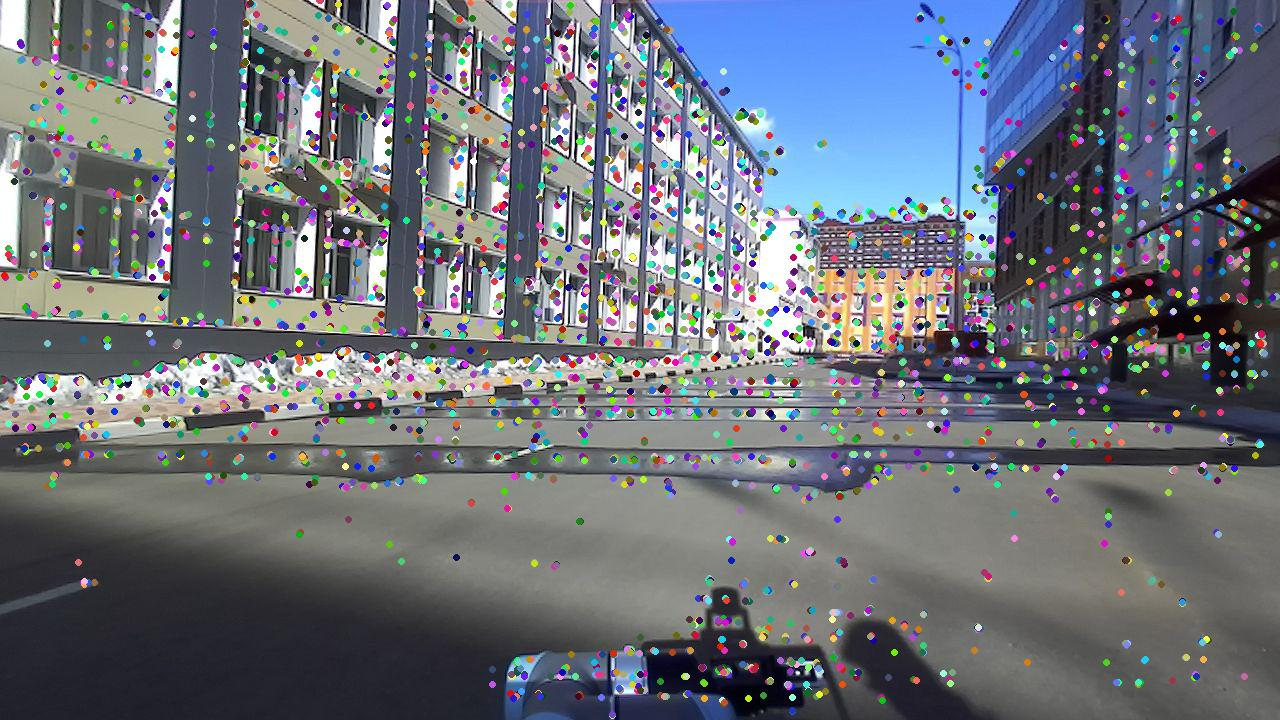

#RESULTS

In [203]:
!rm -rf 'YaProfi/local_features'
!rm -rf 'YaProfi/global_features'

!mkdir YaProfi/local_features
!mkdir YaProfi/global_features
!mkdir YaProfi/local_features/r2d2_500
!mkdir YaProfi/local_features/r2d2_500/keypoints
!mkdir YaProfi/local_features/r2d2_500/descriptors
!mkdir 'YaProfi/local_features/r2d2_500/keypoints/Test'
!mkdir 'YaProfi/local_features/r2d2_500/keypoints/Train'
!mkdir 'YaProfi/local_features/r2d2_500/descriptors/Test'
!mkdir 'YaProfi/local_features/r2d2_500/descriptors/Train'
!mkdir YaProfi/global_features/AP-GeM-LM18
!mkdir YaProfi/global_features/AP-GeM-LM18/global_features
!mkdir YaProfi/global_features/AP-GeM-LM18/global_features/Test
!mkdir YaProfi/global_features/AP-GeM-LM18/global_features/Train

!cp YaProfi/query/reconstruction/keypoints/keypoints.txt YaProfi/local_features/r2d2_500/keypoints
!cp YaProfi/query/reconstruction/descriptors/descriptors.txt YaProfi/local_features/r2d2_500/descriptors
!cp YaProfi/query/reconstruction/global_features/global_features.txt YaProfi/global_features/AP-GeM-LM18/global_features

In [213]:
!python3 repo/kapture-localization/tools/kapture_compute_matches.py -i YaProfi/map_plus_query --pairsfile-path pairs_mapping_3.txt 

In [255]:
import shutil

source_gfeat_query = 'YaProfi/query/reconstruction/global_features/Test'
dest_gfeat_query = 'YaProfi/global_features/AP-GeM-LM18/global_features/Test'

source_kpt_query = 'YaProfi/query/reconstruction/keypoints/Test'
dest_kpt_query = 'YaProfi/local_features/r2d2_500/keypoints/Test'

source_desc_query = 'YaProfi/query/reconstruction/descriptors/Test'
dest_desc_query = 'YaProfi/local_features/r2d2_500/descriptors/Test'

source_gfeat_mapping = 'YaProfi/mapping/reconstruction/global_features/Train'
dest_gfeat_mapping = 'YaProfi/global_features/AP-GeM-LM18/global_features/Train'

source_kpt_mapping = 'YaProfi/mapping/reconstruction/keypoints/Train'
dest_kpt_mapping = 'YaProfi/local_features/r2d2_500/keypoints/Train'

source_desc_mapping = 'YaProfi/mapping/reconstruction/descriptors/Train'
dest_desc_mapping = 'YaProfi/local_features/r2d2_500/descriptors/Train'

source = [source_gfeat_query,source_kpt_query,source_desc_query,source_gfeat_mapping,source_kpt_mapping,source_desc_mapping]
destination = [dest_gfeat_query,dest_kpt_query, dest_desc_query,dest_gfeat_mapping,dest_kpt_mapping,dest_desc_mapping]

for s,d in zip(source,destination):
    print(s,d)
    shutil.copytree(s, d)


YaProfi/query/reconstruction/global_features/Test YaProfi/global_features/AP-GeM-LM18/global_features/Test


FileNotFoundError: [Errno 2] No such file or directory: 'YaProfi/query/reconstruction/global_features/Test'

In [249]:
%cd YaProfi
!python3 /opt/src/YaProfi/repo/kapture-localization/pipeline/kapture_pipeline_mapping.py -v info \
    -i ./mapping \
    -kpt ./local_features/r2d2_500/keypoints \
    -desc ./local_features/r2d2_500/descriptors \
    -gfeat ./global_features/AP-GeM-LM18/global_features \
    -matches ./local_features/r2d2_500/NN_no_gv/matches \
    -matches-gv ./local_features/r2d2_500/NN_colmap_gv/matches \
    --colmap-map ./colmap-sfm/r2d2_500/AP-GeM-LM18_top5 \
    --topk 5 
%cd ..

/opt/src/YaProfi/YaProfi
INFO    ::compute_image_pairs: compute_image_pairs. loading mapping: ./colmap-sfm/r2d2_500/AP-GeM-LM18_top5/kapture_inputs/proxy_mapping
INFO    ::compute_image_pairs: computing pairs with dirtorch...
INFO    ::compute_image_pairs: saving to file  ...
INFO    ::compute_image_pairs: all done
INFO    ::compute_matches: compute_matches. loading input: ./colmap-sfm/r2d2_500/AP-GeM-LM18_top5/kapture_inputs/proxy_mapping
INFO    ::compute_matches: reading pairs from pairsfile
INFO    ::compute_matches: compute_matches. entering main loop...
0it [00:00, ?it/s]
INFO    ::compute_matches: all done
INFO    ::run_colmap_gv: run_colmap_gv...
Traceback (most recent call last):
  File "/opt/src/YaProfi/repo/kapture-localization/tools/kapture_run_colmap_gv.py", line 156, in <module>
    run_colmap_gv_command_line()
  File "/opt/src/YaProfi/repo/kapture-localization/tools/kapture_run_colmap_gv.py", line 152, in run_colmap_gv_command_line
    run_colmap_gv(args.input, args.outp

In [ ]:
%cd /content/repo/kapture-localization/samples/habitat/
!python /content/repo/kapture-localization/pipeline/kapture_pipeline_localize.py -v info \
      -i ./mapping \
      --query ./query \
      -kpt ./local_features/r2d2_500/keypoints \
      -desc ./local_features/r2d2_500/descriptors \
      -gfeat ./global_features/AP-GeM-LM18/global_features \
      -matches ./local_features/r2d2_500/NN_no_gv/matches \
      -matches-gv ./local_features/r2d2_500/NN_colmap_gv/matches \
      --colmap-map ./colmap-sfm/r2d2_500/AP-GeM-LM18_top5 \
      -o ./colmap-localization/r2d2_500/AP-GeM-LM18_top5/AP-GeM-LM18_top5/ \
      --topk 5 \
      --config 2

In [248]:
!rm -rf YaProfi/colmap-sfm

In [230]:
!pwd

/opt/src/YaProfi


In [247]:
#!python3 repo/kapture-localization/tools/kapture_compute_image_pairs.py --query YaProfi/query --mapping YaProfi/mapping -o pairs_mapping_3.txt --topk 3 
#!python3 repo/kapture/tools/kapture_merge.py -i YaProfi/query YaProfi/mapping -o YaProfi/map_plus_query


In [245]:
!rm -rf /opt/src/YaProfi/YaProfi/local_features/r2d2_500/NN_colmap_gv/matches/matches/matches

In [284]:
del structure